<a href="https://colab.research.google.com/github/peterbabulik/ETA/blob/main/BB84KeyDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The Secure Key Exchange Problem

**The Math:** Generate a shared secret key between two parties.
$$ K_{shared} = K_{Alice} \cap K_{Bob} $$

Classically, key exchange (like Diffie-Hellman) relies on computational hardness assumptions. A sufficiently powerful computer could break these.

**Quantum Advantage:** BB84 provides **unconditional security** based on the laws of physics, not computational assumptions.

### The Quantum Translation: BB84 Protocol

BB84 (Bennett-Brassard 1984) is the first quantum key distribution protocol. It uses the quantum property that measurement disturbs the state to detect eavesdropping.

**The Logic:**
1. **Alice sends:** Random bits in random bases (Z or X).
2. **Bob measures:** Random basis choice for each qubit.
3. **Basis reconciliation:** Alice and Bob announce their bases (not bits).
4. **Key sifting:** Keep only bits where bases matched.
5. **Error checking:** Sample some bits to detect eavesdropping.
6. **Final key:** Remaining bits form the shared secret key.

**Analogy for Python Devs:**
Think of this as `generate_secure_key()` - like RSA key exchange, but provably secure against any attacker, even with unlimited computing power.

### The Qiskit Implementation

We'll simulate the BB84 protocol between Alice and Bob, including an eavesdropper (Eve).

In [1]:
!pip install qiskit qiskit-aer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import random

# -------------------------------------------------------
# BB84 PROTOCOL IMPLEMENTATION
# -------------------------------------------------------

def encode_bit(bit, basis):
    """
    Encodes a bit in a given basis.

    Basis 0 (Z basis): |0> for bit 0, |1> for bit 1
    Basis 1 (X basis): |+> for bit 0, |-> for bit 1

    |+> = H|0> = (|0> + |1>)/sqrt(2)
    |-> = H|1> = (|0> - |1>)/sqrt(2)
    """
    qc = QuantumCircuit(1, 1)

    if bit == 1:
        qc.x(0)  # Flip to |1>

    if basis == 1:  # X basis
        qc.h(0)  # Apply Hadamard

    return qc

def measure_bit(qc, basis):
    """
    Measures a qubit in a given basis.

    Z basis: Measure directly
    X basis: Apply H first, then measure
    """
    if basis == 1:  # X basis
        qc.h(0)  # Rotate to Z basis

    qc.measure(0, 0)
    return qc

def simulate_bb84(n_bits, eve_present=False):
    """
    Simulates the complete BB84 protocol.

    Args:
        n_bits: Number of bits to transmit
        eve_present: Whether Eve is eavesdropping

    Returns:
        Dictionary with protocol results
    """
    simulator = AerSimulator()

    # Alice's random choices
    alice_bits = [random.randint(0, 1) for _ in range(n_bits)]
    alice_bases = [random.randint(0, 1) for _ in range(n_bits)]

    # Bob's random basis choices
    bob_bases = [random.randint(0, 1) for _ in range(n_bits)]

    # Eve's basis choices (if present)
    if eve_present:
        eve_bases = [random.randint(0, 1) for _ in range(n_bits)]

    bob_results = []

    # Simulate each qubit transmission
    for i in range(n_bits):
        # Alice encodes
        qc = encode_bit(alice_bits[i], alice_bases[i])

        # Eve intercepts (if present)
        if eve_present:
            # Eve measures in her random basis
            qc = measure_bit(qc, eve_bases[i])
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled, shots=1)
            eve_result = int(list(job.result().get_counts().keys())[0])

            # Eve resends in her measured state
            qc = QuantumCircuit(1, 1)
            if eve_result == 1:
                qc.x(0)
            if eve_bases[i] == 1:
                qc.h(0)

        # Bob measures
        qc = measure_bit(qc, bob_bases[i])
        compiled = transpile(qc, simulator)
        job = simulator.run(compiled, shots=1)
        bob_result = int(list(job.result().get_counts().keys())[0])
        bob_results.append(bob_result)

    # Basis reconciliation (public discussion)
    matching_bases = [i for i in range(n_bits) if alice_bases[i] == bob_bases[i]]

    # Key sifting - keep only matching basis bits
    alice_key = [alice_bits[i] for i in matching_bases]
    bob_key = [bob_results[i] for i in matching_bases]

    # Calculate error rate
    errors = sum(1 for a, b in zip(alice_key, bob_key) if a != b)
    error_rate = errors / len(alice_key) if alice_key else 0

    return {
        'n_bits': n_bits,
        'alice_bits': alice_bits,
        'alice_bases': alice_bases,
        'bob_bases': bob_bases,
        'bob_results': bob_results,
        'matching_bases': matching_bases,
        'alice_key': alice_key,
        'bob_key': bob_key,
        'key_length': len(alice_key),
        'errors': errors,
        'error_rate': error_rate,
        'eve_present': eve_present
    }

# -------------------------------------------------------
# Run BB84 Simulation
# -------------------------------------------------------

print("=== BB84 Quantum Key Distribution ===")
print("\nGenerating a shared secret key using quantum mechanics.\n")

# Parameters
n_bits = 100

# Run without Eve
print("--- Scenario 1: No Eavesdropper ---")
result_no_eve = simulate_bb84(n_bits, eve_present=False)

print(f"Bits transmitted: {result_no_eve['n_bits']}")
print(f"Matching bases: {len(result_no_eve['matching_bases'])}")
print(f"Key length (sifted): {result_no_eve['key_length']}")
print(f"Errors: {result_no_eve['errors']}")
print(f"Error rate: {result_no_eve['error_rate']:.2%}")
print(f"\nAlice's key (first 20): {result_no_eve['alice_key'][:20]}")
print(f"Bob's key (first 20):   {result_no_eve['bob_key'][:20]}")
print(f"\nKeys match: {result_no_eve['alice_key'] == result_no_eve['bob_key']}")

# Run with Eve
print("\n" + "="*50)
print("--- Scenario 2: With Eavesdropper (Eve) ---")
result_with_eve = simulate_bb84(n_bits, eve_present=True)

print(f"Bits transmitted: {result_with_eve['n_bits']}")
print(f"Matching bases: {len(result_with_eve['matching_bases'])}")
print(f"Key length (sifted): {result_with_eve['key_length']}")
print(f"Errors: {result_with_eve['errors']}")
print(f"Error rate: {result_with_eve['error_rate']:.2%}")
print(f"\nAlice's key (first 20): {result_with_eve['alice_key'][:20]}")
print(f"Bob's key (first 20):   {result_with_eve['bob_key'][:20]}")
print(f"\nKeys match: {result_with_eve['alice_key'] == result_with_eve['bob_key']}")

=== BB84 Quantum Key Distribution ===

Generating a shared secret key using quantum mechanics.

--- Scenario 1: No Eavesdropper ---
Bits transmitted: 100
Matching bases: 46
Key length (sifted): 46
Errors: 0
Error rate: 0.00%

Alice's key (first 20): [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Bob's key (first 20):   [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]

Keys match: True

--- Scenario 2: With Eavesdropper (Eve) ---
Bits transmitted: 100
Matching bases: 50
Key length (sifted): 50
Errors: 11
Error rate: 22.00%

Alice's key (first 20): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Bob's key (first 20):   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]

Keys match: False


Running multiple simulations...

--- Statistical Analysis ---

Without Eve:
  Mean error rate: 0.00%
  Std deviation: 0.00%

With Eve:
  Mean error rate: 25.35%
  Std deviation: 6.70%

Theoretical error rate with Eve: 25%
  (Eve uses wrong basis 50% × Bob uses matching basis 50% = 25%)


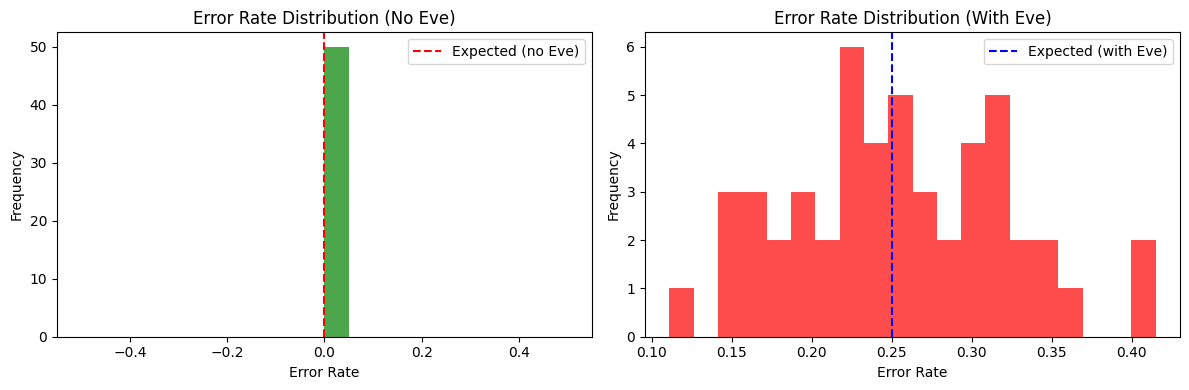

In [4]:
# Visualize the error detection
import matplotlib.pyplot as plt

# Run multiple simulations to show statistics
n_simulations = 50
error_rates_no_eve = []
error_rates_with_eve = []

print("Running multiple simulations...")
for _ in range(n_simulations):
    result = simulate_bb84(100, eve_present=False) # Corrected typo from simulate_bb64 to simulate_bb84
    error_rates_no_eve.append(result['error_rate'])

    result = simulate_bb84(100, eve_present=True)
    error_rates_with_eve.append(result['error_rate'])

print("\n--- Statistical Analysis ---")
print(f"\nWithout Eve:")
print(f"  Mean error rate: {np.mean(error_rates_no_eve):.2%}")
print(f"  Std deviation: {np.std(error_rates_no_eve):.2%}")

print(f"\nWith Eve:")
print(f"  Mean error rate: {np.mean(error_rates_with_eve):.2%}")
print(f"  Std deviation: {np.std(error_rates_with_eve):.2%}")

# Theoretical error rate with Eve: 25%
# (Eve guesses wrong basis 50% of time, then Bob measures wrong 50% of those)
print(f"\nTheoretical error rate with Eve: 25%")
print(f"  (Eve uses wrong basis 50% × Bob uses matching basis 50% = 25%)")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(error_rates_no_eve, bins=20, alpha=0.7, color='green')
ax1.axvline(x=0, color='red', linestyle='--', label='Expected (no Eve)')
ax1.set_xlabel('Error Rate')
ax1.set_ylabel('Frequency')
ax1.set_title('Error Rate Distribution (No Eve)')
ax1.legend()

ax2.hist(error_rates_with_eve, bins=20, alpha=0.7, color='red')
ax2.axvline(x=0.25, color='blue', linestyle='--', label='Expected (with Eve)')
ax2.set_xlabel('Error Rate')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Rate Distribution (With Eve)')
ax2.legend()

plt.tight_layout()
plt.show()

In [5]:
# Demonstrate the protocol steps visually

print("\n=== BB84 Protocol Step-by-Step ===")
print("\nLet's trace through a single qubit transmission:\n")

# Single qubit example
alice_bit = 1
alice_basis = 1  # X basis
bob_basis = 1    # X basis (matching)

print(f"Step 1: Alice wants to send bit {alice_bit}")
print(f"Step 2: Alice randomly chooses basis {['Z', 'X'][alice_basis]}")
print(f"        She encodes: |{'1' if alice_basis == 0 else '+' if alice_bit == 0 else '-'}>")

print(f"\nStep 3: Bob randomly chooses basis {['Z', 'X'][bob_basis]}")
if alice_basis == bob_basis:
    print(f"        Bases MATCH! Bob will measure correctly.")
else:
    print(f"        Bases MISMATCH! Bob's result is random.")

print(f"\nStep 4: Bob measures and gets the correct bit: {alice_bit}")
print(f"\nStep 5: In basis reconciliation, they keep this bit.")

# Show encoding circuit
print("\n--- Encoding Circuit (Alice) ---")
qc = encode_bit(alice_bit, alice_basis)
print(qc.draw(output='text'))

print("\n--- Measurement Circuit (Bob) ---")
qc = measure_bit(QuantumCircuit(1, 1), bob_basis)
print(qc.draw(output='text'))


=== BB84 Protocol Step-by-Step ===

Let's trace through a single qubit transmission:

Step 1: Alice wants to send bit 1
Step 2: Alice randomly chooses basis X
        She encodes: |->

Step 3: Bob randomly chooses basis X
        Bases MATCH! Bob will measure correctly.

Step 4: Bob measures and gets the correct bit: 1

Step 5: In basis reconciliation, they keep this bit.

--- Encoding Circuit (Alice) ---
     ┌───┐┌───┐
  q: ┤ X ├┤ H ├
     └───┘└───┘
c: 1/══════════
               

--- Measurement Circuit (Bob) ---
     ┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 


### Understanding the Translation

1. **$K_{shared} = K_{Alice} \cap K_{Bob}$ (Key Agreement):**
   - Classical: Rely on computational hardness (RSA, Diffie-Hellman).
   - Quantum: Rely on physics - measurement disturbs quantum states.

2. **Security from Physics:**
   - If Eve measures in the wrong basis, she disturbs the state.
   - This creates errors that Alice and Bob can detect.
   - Theoretical error rate with Eve: 25%.

3. **Two Bases:**
   - Z basis (computational): $|0\rangle$, $|1\rangle$
   - X basis (Hadamard): $|+\rangle$, $|-\rangle$
   - Measuring in the wrong basis gives a random result.

### Why is this useful?

**Unconditional Security:** Security is guaranteed by the laws of quantum mechanics, not computational assumptions.

**Eavesdropper Detection:** Any attempt to intercept the key is detectable.

**Real-World Use:** BB84 has been implemented over 100+ km of fiber optic cable and is commercially available.

### Protocol Summary

| Step | Action | Public/Private |
|------|--------|---------------|
| 1 | Alice chooses random bits and bases | Private |
| 2 | Alice sends qubits | Quantum channel |
| 3 | Bob measures in random bases | Private |
| 4 | Alice and Bob announce bases | Public |
| 5 | Keep bits where bases matched | Private |
| 6 | Check error rate on sample | Public |
| 7 | Use remaining bits as key | Private |

### Summary for Python Developers

```python
# Classical key exchange (RSA-like)
def classical_key_exchange():
    # Security relies on hard math problems
    # Vulnerable to quantum computers (Shor's algorithm)
    return shared_key

# BB84 Quantum Key Distribution
def bb84_key_distribution():
    # Security relies on laws of physics
    # Provably secure even against quantum computers
    
    # 1. Alice sends random bits in random bases
    # 2. Bob measures in random bases
    # 3. They compare bases (not bits!) publicly
    # 4. Keep matching-basis bits as key
    # 5. Check for eavesdropping via error rate
    
    return shared_key  # Provably secure!
```